In [2]:
import pandas as pd
import os
import requests
import time
import datetime

from geopy.distance import geodesic
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np

import contextily as ctx

from haversine import haversine, Unit
import missingno as mn
from shapely.geometry import Point
import seaborn as sns
from wordcloud import WordCloud

# Add Map with buules to show Night hours accidents location amd number of bar >30

In [3]:
df = pd.read_csv('gdf.csv', encoding="unicode_escape")


In [4]:
df.head()

,Master Record Number,Date,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude,Location,Number of Bars,Weather Condition,Severity,geometry,area_number
0,902582972,2015-12-04,Weekday,22:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,2ND & HIGH,39.160944,-86.508288,"39.160944,-86.508288",7,Clear,1,POINT (-86.508288 39.160944),0
1,902484079,2015-07-06,Weekday,13:00:00,2-Car,Incapacitating,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,S LEONARD SPRINGS,39.142048,-86.582592,"39.142048,-86.582592",1,Clear,2,POINT (-86.582592 39.142048),0
2,902399070,2015-02-06,Weekday,16:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,BARGE & S LEONARD SPRINGS,39.135797,-86.582496,"39.13579732,-86.582496",1,Clear,1,POINT (-86.582496 39.13579732),0
3,902403874,2015-02-06,Weekday,13:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,GRAHAM & ROGERS,39.139920,-86.538416,"39.13992,-86.538416",2,Clear,1,POINT (-86.538416 39.13992),0
4,902471166,2015-06-06,Weekday,05:00:00,1-Car,No injury/unknown,ANIMAL/OBJECT IN ROADWAY,SR37N & WYLIE,39.198571,-86.529524,"39.19857096,-86.5295245",0,Clear,1,POINT (-86.5295245 39.19857096),0


##### Columns in dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Master Record Number  500 non-null    int64  
 1   Date                  500 non-null    object 
 2   Weekend?              500 non-null    object 
 3   Hour                  500 non-null    object 
 4   Collision Type        500 non-null    object 
 5   Injury Type           500 non-null    object 
 6   Primary Factor        488 non-null    object 
 7   Reported_Location     500 non-null    object 
 8   Latitude              500 non-null    float64
 9   Longitude             500 non-null    float64
 10  Location              500 non-null    object 
 11  Number of Bars        500 non-null    int64  
 12  Weather Condition     500 non-null    object 
 13  Severity              500 non-null    int64  
 14  geometry              500 non-null    object 
 15  area_number           5

##### Statistical Description of each column

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Master Record Number,500.0,9.024776e+08,66987.670958,9.023644e+08,9.024183e+08,9.024725e+08,9.025354e+08,9.026161e+08
Latitude,500.0,3.916404e+01,0.051463,3.889756e+01,3.915050e+01,3.916464e+01,3.917213e+01,3.973761e+01
Longitude,500.0,-8.653834e+01,0.043166,-8.668490e+01,-8.656253e+01,-8.653357e+01,-8.651641e+01,-8.627473e+01
Number of Bars,500.0,1.342600e+01,16.847201,0.000000e+00,7.500000e-01,5.000000e+00,3.300000e+01,4.300000e+01
Severity,500.0,1.188000e+00,0.401221,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
area_number,500.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


##### Numerical Columns to deal with

In [7]:
# int, float and boolean data
print(df.count(numeric_only=True))
print("Total No. of Numerical Columns:", len(df.count(numeric_only=True)))

Master Record Number    500
Latitude                500
Longitude               500
Number of Bars          500
Severity                500
area_number             500
dtype: int64
Total No. of Numerical Columns: 6


##### Percentage of Missing Values

In [8]:
missing_values = df.isna().sum().sort_values(ascending=False)
missing_percentage = missing_values[missing_values!=0]/len(df)*100
print(" Percentage of Missing Values \n", missing_percentage)

 Percentage of Missing Values 
 Primary Factor    2.4
dtype: float64


##### Getting List of Columns Having Null Values

In [9]:
null_cols = [i for i in df.columns if df[i].isnull().any()]
print(null_cols)

['Primary Factor']


In [10]:
#Checking Missing Values Pattern in Dataframe
#mn.matrix(df[null_cols]);

In [11]:
#Drop Four Columns [End_Lng, End_Lat, Number, TMC ] having high no. of Missing Values
#new_data_a = df.drop(columns=["End_Lng", "End_Lat", "Number"], axis=0)
#Drop Rows w.r.t to columns having least percentage of missing values (do not effect much to data with 4.2 million records)
#
#new_data_b = new_data_a.dropna(subset = ['Visibility(mi)','Weather_Condition','Humidity(%)','Temperature(F)','Wind_Direction','Pressure(in)','Weather_
#new_data_b.isnull().sum()
#final_data = new_data_b.drop(columns = 'ID', axis=0)
#final_data.isnull().sum()


### Where accidents happend - exploring location and mapping

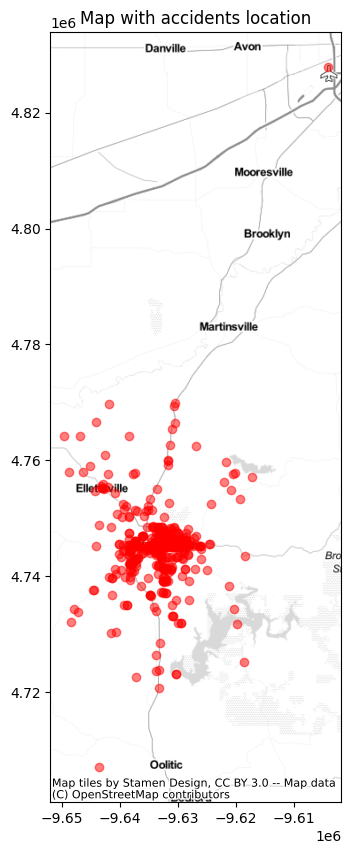

In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Set the CRS to WGS84 (EPSG code 4326)
gdf.set_crs(epsg=4326, inplace=True)

# Define the basemap
basemap = ctx.providers.Stamen.TonerLite

# Plot the points on the map with the basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, zoom=10, source=basemap)

plt.title("Map with accidents location")
plt.show()

### Correlation betwen Bars, Car accidents and Severity

### Heat map for 2015 to represent the density of traffic accidents, Monroe County, USA. 
  <!-- ![image.png](attachment:image.png) -->

In [13]:
import folium
from folium.plugins import HeatMap

map_center = [gdf['Latitude'].mean(), gdf['Longitude'].mean()]
gdf_map1 = folium.Map(location=map_center, zoom_start=12)

heat_data = gdf[['Latitude', 'Longitude']]
HeatMap(heat_data, radius=10).add_to(gdf_map1)

gdf_map1.save('heatmap.html') #save as html and open on browser 
gdf_map1

### Map represents location of accidents and density of bars 
- <span style="color: red;"> Red </span> - accident location, where the number of bars is higher  10
- <span style="color: blue;"> Blue </span> - accident location, where the numbers of bars less than 10
- <span style="color: green;">Green</span> - Bars Location 


In [14]:
import folium


bar_dens = 11
df_filtered = gdf[gdf['Number of Bars'] >= bar_dens]


m = folium.Map(location=[39.160944, - 86.508288], zoom_start=12)


fg_bars = folium.FeatureGroup(name='Bars')
fg_accidents = folium.FeatureGroup(name='Car Accidents')


for i, row in df_filtered.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    popup_text = f"Name: {row['Reported_Location']}<br>Number of Bars: {row['Number of Bars']}"
    marker = folium.Marker(location=[lat, lon], popup=popup_text, icon=folium.Icon(color='green'))
    marker.add_to(fg_bars)


for i, row in df.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    popup_text = f"Severity: {row['Severity']}<br>Collision Type: {row['Collision Type']}"
    if row['Number of Bars'] >= bar_dens:
        
        marker = folium.Marker(location=[lat, lon], popup=popup_text, icon=folium.Icon(color='red'))
    else:
        
        marker = folium.Marker(location=[lat, lon], popup=popup_text, icon=folium.Icon(color='blue'))
    marker.add_to(fg_accidents)


fg_bars.add_to(m)
fg_accidents.add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

#### Calculate the total number of accidents within 1 mile of a Number of bars >=30

In [15]:
# Calculate the total number of accidents within 1 mile of a bar
high_density_bars = gdf[gdf['Number of Bars'] >= 30]
total_accidents = high_density_bars['Master Record Number'].count()
total_accidents 

135

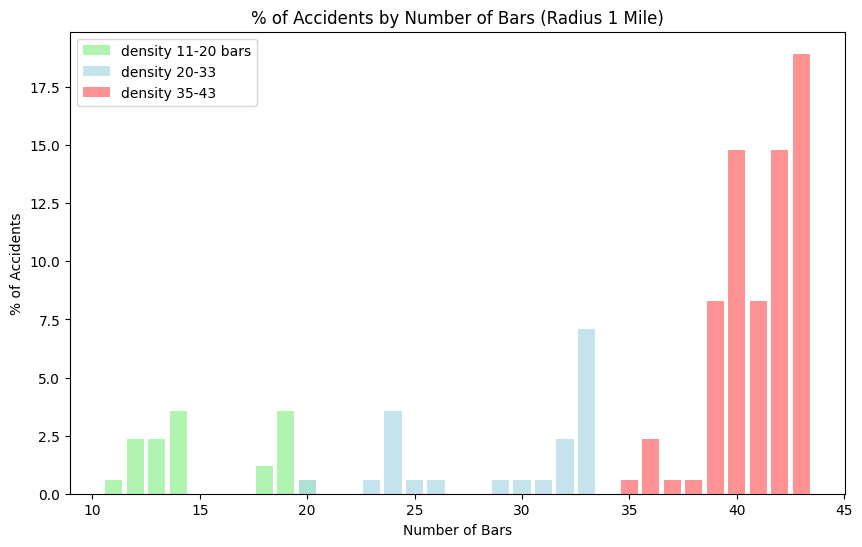

In [16]:

high_density_bars = gdf[gdf['Number of Bars'] >= 11]
total_accidents = high_density_bars['Master Record Number'].count()


mean_accidents_per_bar = high_density_bars.groupby('Number of Bars')['Master Record Number'].count().reset_index(name='Accident Count')
mean_accidents_per_bar['% Accidents'] = (mean_accidents_per_bar['Accident Count'] / total_accidents) * 100


range_11_20 = mean_accidents_per_bar.loc[mean_accidents_per_bar['Number of Bars'].between(11, 20)]
range_20_33 = mean_accidents_per_bar.loc[mean_accidents_per_bar['Number of Bars'].between(20, 33)]
range_35_43 = mean_accidents_per_bar.loc[mean_accidents_per_bar['Number of Bars'].between(35, 43)]

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(range_11_20['Number of Bars'], range_11_20['% Accidents'], color='lightgreen', alpha=0.7, label='density 11-20 bars')
plt.bar(range_20_33['Number of Bars'], range_20_33['% Accidents'], color='lightblue', alpha=0.7, label='density 20-33')
plt.bar(range_35_43['Number of Bars'], range_35_43['% Accidents'], color= '#FF6666', alpha=0.7, label='density 35-43')
plt.xlabel('Number of Bars')
plt.ylabel('% of Accidents')
plt.title('% of Accidents by Number of Bars (Radius 1 Mile)')
plt.legend()
plt.show()


### Collision Type

In [17]:
collision_count = gdf.groupby('Collision Type').size()
collision_count

Collision Type
1-Car               105
2-Car               348
3+ Cars              21
Bus                   8
Cyclist               4
Moped/Motorcycle      9
Pedestrian            5
dtype: int64

#### Severity and Type of Collition
- 'No injury/unknown' - 1
-  'Non-incapacitating', 'Incapacitating' -2
- 'Fatal'- 3

#### Total severity for each type

In [18]:
severity_counts = df.groupby('Severity').size()
severity_counts

Severity
1    408
2     90
3      2
dtype: int64

#### Accidents by Collision Type and Severity

In [19]:
severity_by_type = gdf.groupby(['Collision Type', 'Severity']).size().unstack()
severity_by_type

Severity,1,2,3
Collision Type,,,
1-Car,88.0,17.0,NaN
2-Car,298.0,49.0,1.0
3+ Cars,11.0,10.0,NaN
Bus,8.0,NaN,NaN
Cyclist,1.0,3.0,NaN
Moped/Motorcycle,1.0,7.0,1.0
Pedestrian,1.0,4.0,NaN


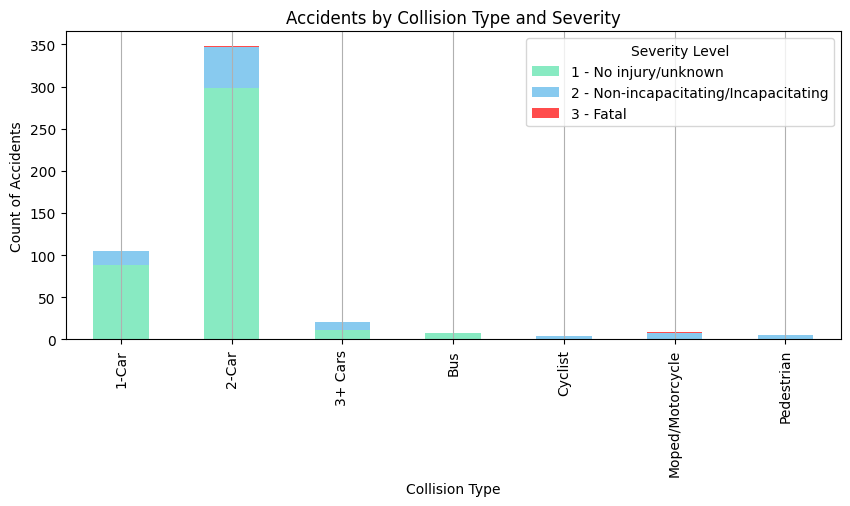

In [20]:
severity_by_type = gdf.groupby(['Collision Type', 'Severity']).size().unstack()

severity_by_type.plot(kind='bar', stacked=True, figsize=(10,4), 
                      color=['#56e2a8', '#56B4E9', 'red'], alpha=0.7)

plt.xlabel('Collision Type')
plt.ylabel('Count of Accidents')
plt.title('Accidents by Collision Type and Severity')
plt.legend(title='Severity Level', labels=['1 - No injury/unknown', '2 - Non-incapacitating/Incapacitating', '3 - Fatal'])
plt.grid(axis='x')


plt.show()

Based on the provided data, the following conclusions:

- The majority of collisions involve 2 cars, with 348 incidents reported, followed by 1-car collisions with 105 incidents reported.
- The most severe collisions (severity level 3) were reported in 2-car and Moped/Motorcycle incidents, with 1 incident reported in 3+ car collisions and pedestrian incidents.

However, it's important to note that the conclusions drawn are based on the data provided and may not be representative of the broader population or other factors that may influence car accidents. Therefore, further analysis and consideration of other factors may be necessary to draw more robust conclusions.

#### Severity Distribution for 2-Car Collisions

In [21]:
two_car_df = gdf[gdf['Collision Type'] == '2-Car']
two_car_df
severity_count = two_car_df['Severity'].value_counts()
severity_count 

1    298
2     49
3      1
Name: Severity, dtype: int64

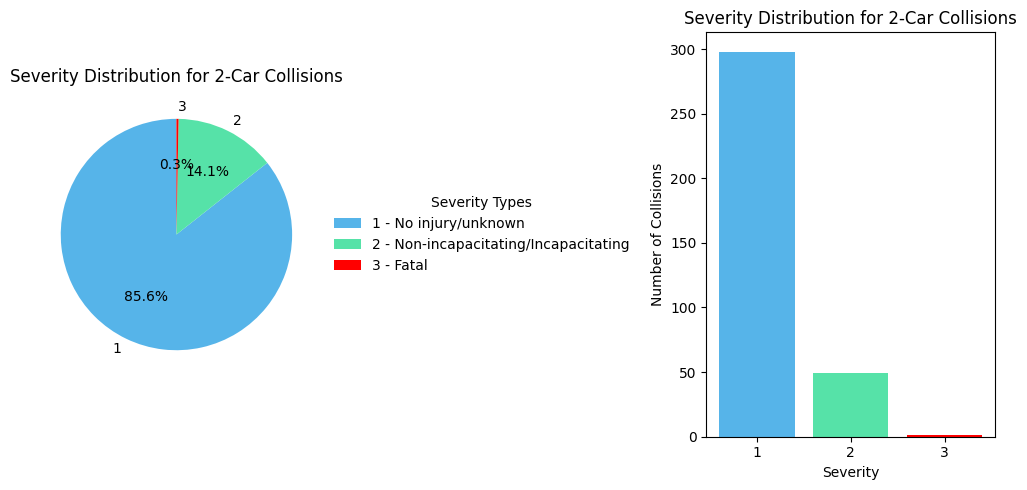

In [22]:
colors = ['#56B4E9', '#56e2a8', 'red']


two_car_df = gdf[gdf['Collision Type'] == '2-Car']

# Count the number of collisions for each severity level
severity_count = two_car_df['Severity'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(severity_count, labels=severity_count.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Severity Distribution for 2-Car Collisions')

ax1.legend(title='Severity Types', labels=['1 - No injury/unknown', '2 - Non-incapacitating/Incapacitating', '3 - Fatal'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

ax2.bar(severity_count.index, severity_count.values, color=colors)
ax2.set_xlabel('Severity')
ax2.set_ylabel('Number of Collisions')
ax2.set_title('Severity Distribution for 2-Car Collisions')

fig.tight_layout()

ax.grid(axis='x', color='gray', linestyle='-', linewidth=0.25)
plt.show()


From the pie chart and bar chart, we can see that the majority of 2-car collisions result in non-incapacitating or incapacitating injuries (87.6%), while a small percentage result in no injury/unknown (12.3%) and an even smaller percentage result in fatal injuries (0.1%). This suggests that 2-car collisions generally result in injuries rather than fatalities, with non-incapacitating or incapacitating injuries being the most common.

#### Analyze the relationship between the number of bars in an area and the severity and frequency of accidents

In [23]:
gdf['bar_location'] = gdf[gdf['Number of Bars'] > 0]['geometry'].apply(lambda x: x.centroid)
gdf['bar_location'] = gdf['bar_location'].apply(lambda x: x.buffer(1/69) if x is not None else None)

def calculate_distance(row):
    return row['geometry'].distance(row['bar_location'])

high_density_bars = gdf[gdf.apply(lambda x: x['Number of Bars'] > 10 and x['geometry'].distance(x['bar_location']) <= 1, axis=1)]

mean_accidents_per_bar = high_density_bars.groupby('Number of Bars').agg({'Master Record Number': 'count', 'Severity': 'mean'})


print(mean_accidents_per_bar.shape)
mean_accidents_per_bar.head()

(25, 2)


,Master Record Number,Severity
Number of Bars,,
11,1,1.000000
12,4,1.000000
13,4,1.000000
14,6,1.333333
18,2,2.000000


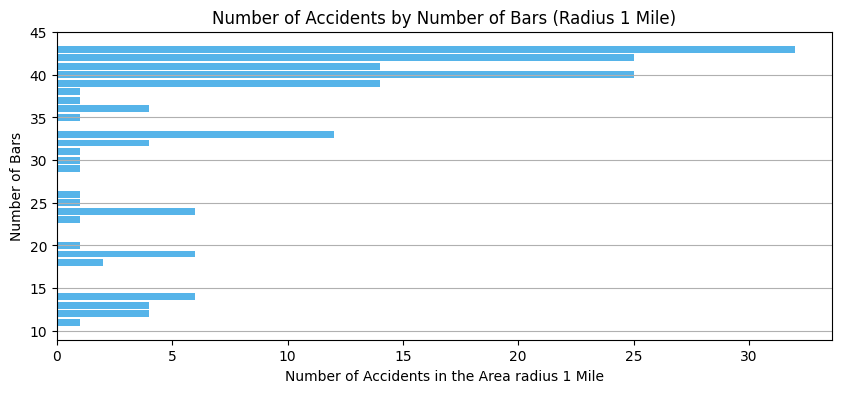

In [24]:
mean_accidents_per_bar = high_density_bars.groupby('Number of Bars').agg({'Master Record Number': 'count', 'Severity': 'mean'})


plt.figure(figsize=(10, 4))
plt.barh(mean_accidents_per_bar.index, mean_accidents_per_bar['Master Record Number'], color= '#56B4E9')
plt.xlabel('Number of Accidents in the Area radius 1 Mile')
plt.ylabel('Number of Bars')
plt.title('Number of Accidents by Number of Bars (Radius 1 Mile)')
plt.grid(axis='y')
plt.show()


Based on the data provided, it appears that there may be a correlation between the number of bars in a given area and the severity of car accidents. The data shows that areas with a higher density of bars (39-43 bars within a radius of 1 mile) tend to have a higher severity rate of accidents, with an average severity rate ranging from 1.04-1.16. On the other hand, areas with a lower density of bars (11-18 bars within a radius of 1 mile) tend to have a lower severity rate of accidents, with an average severity rate ranging from 1.00-2.00.

However, it is important to note that correlation does not necessarily imply causation, and there may be other factors at play that are affecting the severity of car accidents in these areas. Further analysis and data would be needed to make a more conclusive statement.

### Map for Collision type = 2, Severity level, Number of bars > 10
- <span style="color: red;"> Red </span> - Severity = 3 - 'Fatal'
- <span style="color: blue;"> Blue </span> - Severity = 2 - 'Non-incapacitating', 'Incapacitating'
- <span style="color: green;">Green</span> - Severity = 1 - 'No injury/unknown' 

In [25]:

m = folium.Map(location=[39.160944, - 86.508288], zoom_start=12)
color_scheme = {1: 'green', 2: 'blue', 3: 'red'}
for index, row in gdf.iterrows():
    if row['Number of Bars'] > 10 and row['Collision Type'] == '2-Car':
        
        color = color_scheme[row['Severity']]
       
        folium.Marker(location=[row['Latitude'], row['Longitude']],
                      popup=f"Number of Bars: {row['Number of Bars']}<br>Collision Type: {row['Collision Type']}<br>Severity: {row['Severity']}",
                      icon=folium.Icon(color=color)).add_to(m)

m


#### The most frequent street names with the highest number of accidents

In [26]:
accident_counts_by_location = gdf.groupby('Reported_Location').size().reset_index(name='accident_count')
accident_counts_by_location

,Reported_Location,accident_count
0,10TH,1
1,10TH & COLLEGE,2
2,10TH & DUNN,1
3,10TH & GRANT,1
4,10TH & JORDAN,3
...,...,...
426,WALCOTT & WOODYARD,1
427,WALNUT,1
428,WALNUT & WINSLOW,1
429,WALNUT STREET & WINSLOW,1


In [27]:
top_streets = accident_counts_by_location.sort_values(by='accident_count', ascending=False)
top_streets.head(15)


,Reported_Location,accident_count
146,E 3RD,4
136,E 10TH,4
290,N WALNUT,4
350,S WALNUT,4
379,SR37N & VERNAL,3
275,N GATES,3
51,3RD & SWAIN,3
269,N COLLEGE,3
197,EAST 3RD,3
4,10TH & JORDAN,3


#### Accident Locations 

In [28]:
import folium
from folium.plugins import MarkerCluster

accident_counts_by_location = gdf.groupby('Reported_Location').size().reset_index(name='accident_count')

center_lat = gdf['Latitude'].mean()
center_lon = gdf['Longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)


for index, row in accident_counts_by_location.iterrows():
  
    location = gdf[gdf['Reported_Location'] == row['Reported_Location']][['Latitude', 'Longitude']].iloc[0]
    radius = row['accident_count'] * 10  # adjust the circle size based on the accident count
    tooltip = row['Reported_Location'] + ": " + str(row['accident_count']) + " accidents"
    folium.CircleMarker(location=location, radius=radius, tooltip=tooltip, fill=True, fill_opacity=0.7).add_to(marker_cluster)

m



The map shows the distribution of accidents across different locations in the dataset, with the size of the circle indicating the number of accidents that occurred in that location. The markers with larger circles indicate locations with a higher number of accidents, and the tooltip provides additional information on the location and the number of accidents. From the map, we can see that accidents are distributed throughout the city, with several locations having a higher concentration of accidents. This information can be useful for identifying areas that require increased attention to improve road safety.

In [29]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Master Record Number  500 non-null    int64   
 1   Date                  500 non-null    object  
 2   Weekend?              500 non-null    object  
 3   Hour                  500 non-null    object  
 4   Collision Type        500 non-null    object  
 5   Injury Type           500 non-null    object  
 6   Primary Factor        488 non-null    object  
 7   Reported_Location     500 non-null    object  
 8   Latitude              500 non-null    float64 
 9   Longitude             500 non-null    float64 
 10  Location              500 non-null    object  
 11  Number of Bars        500 non-null    int64   
 12  Weather Condition     500 non-null    object  
 13  Severity              500 non-null    int64   
 14  geometry              500 non-null    geometry
 15

#### Analysis of Accidents per Hour of Day during 2015


According to many researches conducted, authors argued that at night drivers are more vulnerable to exceeding the speed limit and driving recklessly. In addition to the negative impact that poor vision might impose on drivers. However, analysis below shows that accidents occur in day time more than Night time. 

In [30]:
gdf['Hour of Day'] = pd.to_datetime(gdf['Hour']).dt.hour
hourly_counts = gdf.groupby('Hour of Day')['Master Record Number'].count()
avg_accidents = int(hourly_counts.mean())
print(f"Average number of accidents per hour during 2015 is {avg_accidents}.")


Average number of accidents per hour during 2015 is 20.


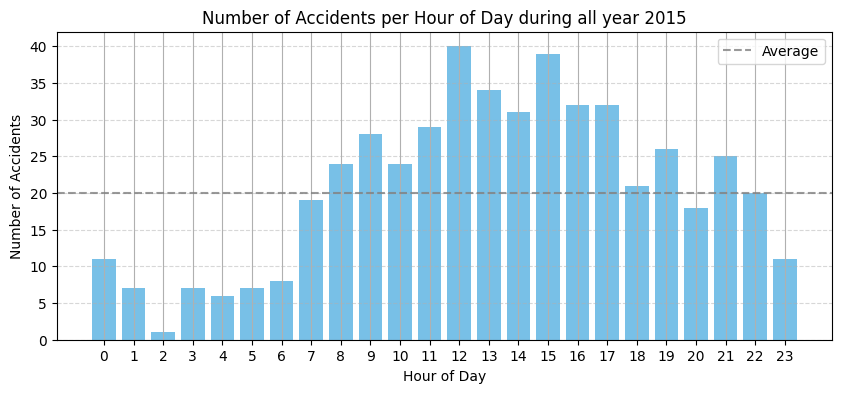

In [31]:
plt.figure(figsize=(10,4))
plt.bar(hourly_counts.index, hourly_counts.values, color='#56b1e2', alpha=0.8)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents per Hour of Day during all year 2015')

plt.xticks(range(24))

plt.axhline(y=avg_accidents, color='grey', linestyle='--', alpha=0.8, label='Average')

plt.legend()
plt.grid(axis='x')


plt.show()


In [32]:
daytime = list(range(6, 19)) # 6am to 6pm
nighttime = list(range(19, 24)) + list(range(0, 6)) # 7pm to 5am

day_data = gdf[gdf['Hour of Day'].isin(daytime)]
night_data = gdf[gdf['Hour of Day'].isin(nighttime)]

day_accidents = len(day_data)
night_accidents = len(night_data)
print(f'Number of accident "Day Hours" 6am to 6pm  = {day_accidents} accidents\nNumber of accident "Night Hours" 7pm to 5am = {night_accidents} accidents')

Number of accident "Day Hours" 6am to 6pm  = 361 accidents
Number of accident "Night Hours" 7pm to 5am = 139 accidents


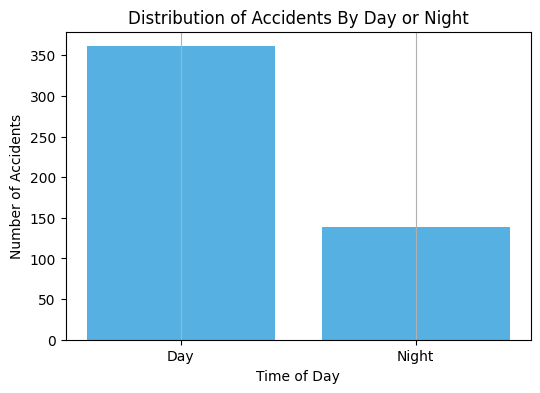

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Day', 'Night'], [day_accidents, night_accidents], color=['#56b1e2', '#56b1e2'])
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Accidents')
ax.set_title('Distribution of Accidents By Day or Night')
#ax.annotate(f"Day time accidents: {day_time}\nNight time accidents: {night_time}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, ha='right', va='right')
ax.grid(axis = 'x')
plt.show()


#### Analysis of Hourly Traffic Accident Severity

This analysis uses a dataset of traffic accident records that includes information such as the severity of the accident and the hour of the day it occurred. The aim of the analysis is to identify patterns in the data and visualize them in a clear and informative way.

In [34]:
severity_counts = df.groupby('Severity').size()
severity_counts

Severity
1    408
2     90
3      2
dtype: int64

In [35]:
severity_data = gdf.groupby(['Severity', 'Hour of Day']).size().reset_index(name='Accidents')
pivot_table = severity_data.pivot(index='Hour of Day', columns='Severity', values='Accidents')
pivot_table.head()

Severity,1,2,3
Hour of Day,,,
0,9.0,2.0,NaN
1,7.0,NaN,NaN
2,1.0,NaN,NaN
3,5.0,2.0,NaN
4,6.0,NaN,NaN


NameError: name 'day_time' is not defined

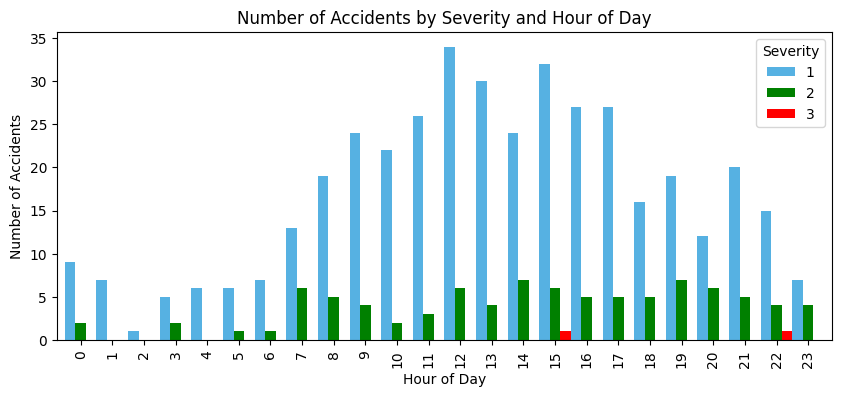

In [36]:
ax = pivot_table.plot(kind='bar', figsize=(10,4), width= 1, color=['#56b1e2', 'green', 'red'])
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Accidents')
ax.set_title('Number of Accidents by Severity and Hour of Day')
ax.annotate(f"Day time accidents: {day_time}\nNight time accidents: {night_time}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.grid(axis='x')
plt.show()


After analyzing the data, it was found that the number of accidents occurring during the day (361 accidents) is significantly higher than during the night  (139 accidents). 

Furthermore, the severity of accidents that occur during the day is higher compared to those that occur during the night. This highlights the importance of taking extra precautions during daylight hours to ensure the safety of all road users. Additionally, it may be useful to implement targeted safety measures during peak hours to reduce the likelihood and severity of accidents.

### Analysis of Accidents and days of weeks during 2015

In [ ]:
gdf['Date'] = pd.to_datetime(gdf['Date'])
gdf['Day of Week'] = gdf['Date'].dt.day_name()

daily_counts = gdf.groupby('Day of Week')['Master Record Number'].count()
daily_counts

Day of Week
Friday       72
Monday       71
Saturday     77
Sunday       69
Thursday     68
Tuesday      74
Wednesday    69
Name: Master Record Number, dtype: int64

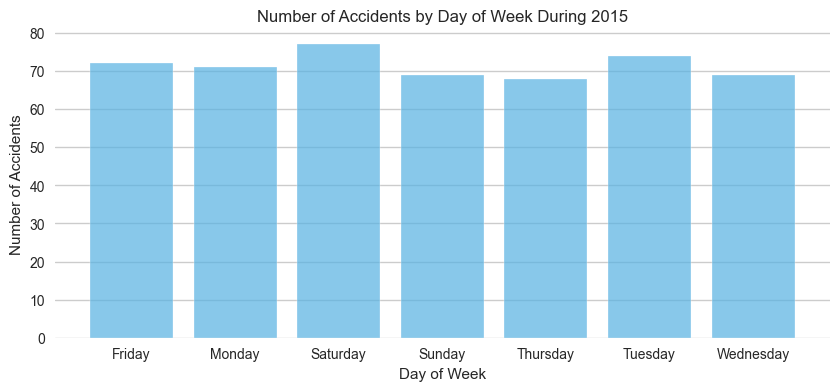

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(daily_counts.index, daily_counts.values, color='#56b1e2', alpha=0.7)
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents by Day of Week During 2015')
plt.grid(axis='x')
plt.show()

In [39]:
import pandas as pd

daytime = list(range(6, 19)) # 6am to 6pm
nighttime = list(range(19, 24)) + list(range(0, 6)) # 7pm to 5am

day_data = gdf[gdf['Hour of Day'].isin(daytime)]
night_data = gdf[gdf['Hour of Day'].isin(nighttime)]

day_accidents = len(day_data)
night_accidents = len(night_data)
print(f'Number of accidents "Day Hours" 6am to 6pm  = {day_accidents} accidents\nNumber of accidents "Night Hours" 7pm to 5am = {night_accidents} accidents') 

gdf['Date'] = pd.to_datetime(gdf['Date'])
gdf['Day of Week'] = gdf['Date'].dt.day_name()

night_data = gdf[gdf['Hour of Day'].isin(nighttime)]
night_counts = night_data.groupby('Day of Week')['Master Record Number'].count()
night_counts


Number of accidents "Day Hours" 6am to 6pm  = 361 accidents
Number of accidents "Night Hours" 7pm to 5am = 139 accidents


Day of Week
Friday       18
Monday       17
Saturday     18
Sunday       23
Thursday     19
Tuesday      26
Wednesday    18
Name: Master Record Number, dtype: int64

#### Number of Accidents at Night by Day of the Week

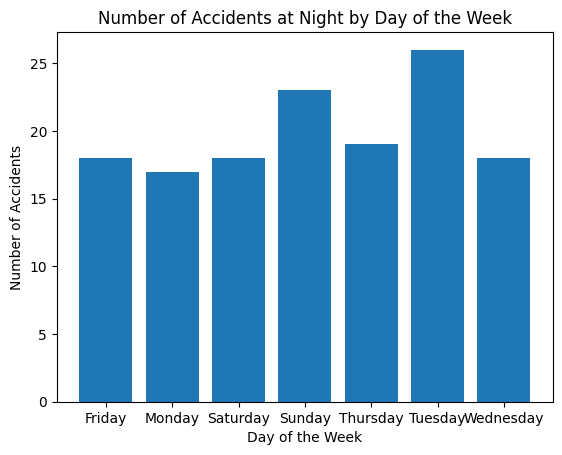

In [40]:
plt.bar(night_counts.index, night_counts.values)
plt.title('Number of Accidents at Night by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.show()

In [41]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

daytime = list(range(6, 19)) # 6am to 6pm
nighttime = list(range(19, 24)) + list(range(0, 6)) # 7pm to 5am

night_data = gdf[gdf['Hour of Day'].isin(nighttime)]

accident_counts_by_location = night_data.groupby('Reported_Location').size().reset_index(name='accident_count')

center_lat = night_data['Latitude'].mean()
center_lon = night_data['Longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)

for index, row in accident_counts_by_location.iterrows():
    location = night_data[night_data['Reported_Location'] == row['Reported_Location']][['Latitude', 'Longitude']].iloc[0]
    radius = row['accident_count'] * 10  # adjust the circle size based on the accident count
    tooltip = row['Reported_Location'] + ": " + str(row['accident_count']) + " accidents"
    folium.CircleMarker(location=location, radius=radius, tooltip=tooltip, fill=True, fill_opacity=0.7).add_to(marker_cluster)

m


In [48]:
import folium
from folium.plugins import MarkerCluster


accident_counts_by_location = night_data.groupby('Reported_Location').size().reset_index(name='accident_count')


center_lat = night_data['Latitude'].mean()
center_lon = night_data['Longitude'].mean()


m = folium.Map(location=[center_lat, center_lon], zoom_start=12)


marker_cluster = MarkerCluster().add_to(m)

#night accidents
for index, row in accident_counts_by_location.iterrows():
    location = night_data[night_data['Reported_Location'] == row['Reported_Location']][['Latitude', 'Longitude']].iloc[0]
    radius = row['accident_count'] * 10  # adjust the circle size based on the accident count
    tooltip = row['Reported_Location'] + ": " + str(row['accident_count']) + " accidents"
    folium.CircleMarker(location=location, radius=radius, tooltip=tooltip, fill=True, fill_opacity=0.7).add_to(marker_cluster)

# Filter bars 
bar_dens = 25
bars_data = gdf[gdf['Number of Bars'] >= bar_dens]


fg_bars = folium.FeatureGroup(name='Bars')


for i, row in bars_data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    popup_text = f"Name: {row['Reported_Location']}<br>Number of Bars: {row['Number of Bars']}"
    marker = folium.Marker(location=[lat, lon], popup=popup_text, icon=folium.Icon(color='green'))
    marker.add_to(fg_bars)

fg_bars.add_to(m)


folium.LayerControl().add_to(m)

m


Based on the provided data, it appears that there is not a significant difference in the number of accidents that occur on each day of the week.

In [45]:
import folium
from folium.plugins import MarkerCluster

bar_dens = 30
bars_data = gdf[gdf['Number of Bars'] >= bar_dens]

center_lat = bars_data['Latitude'].mean()
center_lon = bars_data['Longitude'].mean()


m = folium.Map(location=[center_lat, center_lon], zoom_start=12)


marker_cluster = MarkerCluster().add_to(m)

for i, row in bars_data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    popup_text = f"Name: {row['Reported_Location']}<br>Number of Bars: {row['Number of Bars']}"
    folium.CircleMarker(location=[lat, lon], radius=5, tooltip=popup_text, fill=True, fill_opacity=1, color='red').add_to(marker_cluster)

folium.LayerControl().add_to(m)

m


### Analysis of Accidents Monthly during 2015

In [37]:
gdf['Month'] = pd.to_datetime(gdf['Date']).dt.month

monthly_counts = gdf.groupby('Month')['Master Record Number'].count()
avg_accd_month = monthly_counts.mean()
print(f'The average number of accidents per month during 2015 = {avg_accd_month}')
monthly_counts

The average number of accidents per month during 2015 = 41.666666666666664


Month
1     38
2     54
3     43
4     44
5     39
6     33
7     25
8     32
9     61
10    50
11    45
12    36
Name: Master Record Number, dtype: int64

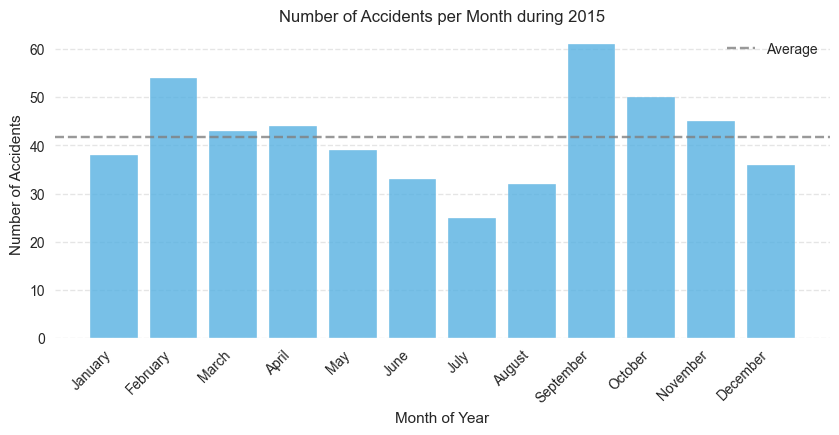

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(monthly_counts.index, monthly_counts.values, color='#56b1e2', alpha=0.8)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xlabel('Month of Year')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents per Month during 2015')

plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45, ha='right')

plt.axhline(y=avg_accd_month, color='grey', linestyle='--', alpha=0.8, label='Average')

plt.legend()
plt.grid(axis='x')
plt.show()


Plot represents accidents distribution through months. The lowest rate occurs in July and August because it is the summer season, students are on vacation, and employees are on leave.

Moreover, the highest ratio occurs at the end of the year which can be attributed to it being on September, the end of year and the holiday season which is a busy season for business.

In [ ]:
uniq_factors = df["Primary Factor"].unique()
uniq_factors
num_unique_factors = df['Primary Factor'].nunique()
num_unique_factors 
value_factors = df['Primary Factor'].value_counts()

value_factors

FAILURE TO YIELD RIGHT OF WAY               95
UNSAFE BACKING                              68
FOLLOWING TOO CLOSELY                       68
OTHER (DRIVER) - EXPLAIN IN NARRATIVE       35
RAN OFF ROAD RIGHT                          33
SPEED TOO FAST FOR WEATHER CONDITIONS       26
ANIMAL/OBJECT IN ROADWAY                    25
UNSAFE LANE MOVEMENT                        20
IMPROPER TURNING                            16
IMPROPER LANE USAGE                         16
DISREGARD SIGNAL/REG SIGN                   15
LEFT OF CENTER                              11
UNSAFE SPEED                                10
DRIVER DISTRACTED - EXPLAIN IN NARRATIVE     9
OTHER (VEHICLE) - EXPLAIN IN NARRATIVE       8
IMPROPER PASSING                             6
OVERCORRECTING/OVERSTEERING                  6
DRIVER ASLEEP OR FATIGUED                    4
OTHER (ENVIRONMENTAL) - EXPLAIN IN NARR      3
ROADWAY SURFACE CONDITION                    2
DRIVER ILLNESS                               2
BRAKE FAILURE

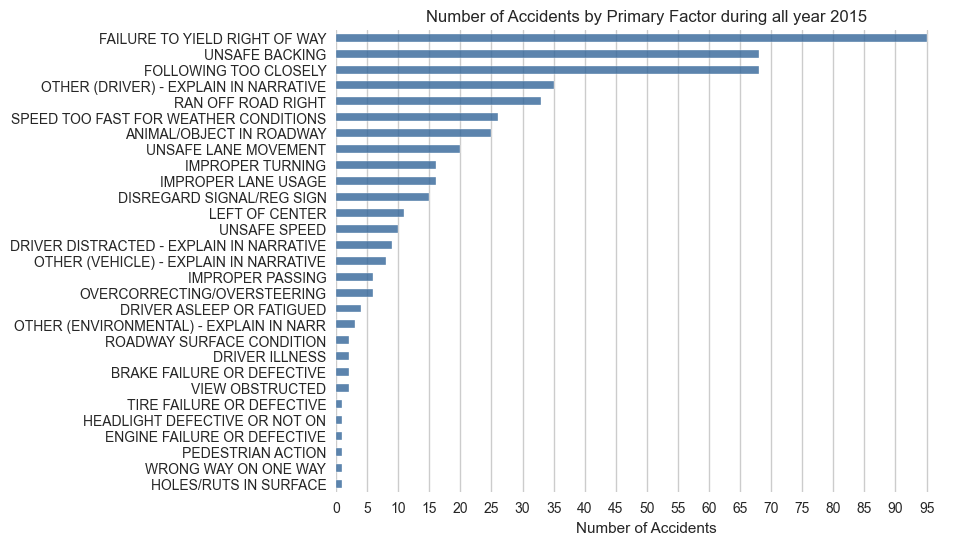

In [ ]:
value_factors = value_factors.sort_values()

plt.figure(figsize=(8,6))
value_factors.plot(kind='barh', color='#336699', alpha=0.8)
plt.xlabel('Number of Accidents')
plt.title('Number of Accidents by Primary Factor during all year 2015')
plt.xticks(range(0, value_factors.max()+1, 5))
plt.grid(axis='y')
plt.show()


The above analysis provides information on the primary factors that contributed to the accidents. "Failure to yield the right of way" was the top primary factor, with 95 occurrences, followed by "Unsafe Backing" and "Following Too Closely", with 68 occurrences each. The data also reveals that some accidents were caused by factors such as "Other (Driver) - Explain in Narrative", "Ran off Road Right", "Speed too fast for weather conditions", and "Animal/Object in Roadway". 

### Weather Condition


Adverse weather conditions can increase the risk of accidents on roads, and analyzing the relationship between weather and accidents can provide insights into which weather conditions are the most dangerous. This can help authorities develop strategies to reduce the risk of accidents during inclement weather. 

Factors like rain, snow, ice, fog, and strong winds can all impact visibility and road conditions, making it more challenging for drivers to control their vehicles, and thus increasing the chances of accidents.

In [ ]:
Weather_Condition = gdf['Weather Condition'].value_counts()
Weather_Condition 

Clear                            308
Overcast                          49
Partly cloudy                     40
Cloudy                            36
Heavy rain at times               19
Patchy rain possible              17
Light freezing rain               11
Patchy moderate snow              10
Moderate rain at times             7
Moderate or heavy rain shower      3
Name: Weather Condition, dtype: int64

#### The most frequently used word is “Clear”, followed by “Overcast” and “Partly cloudy”. 


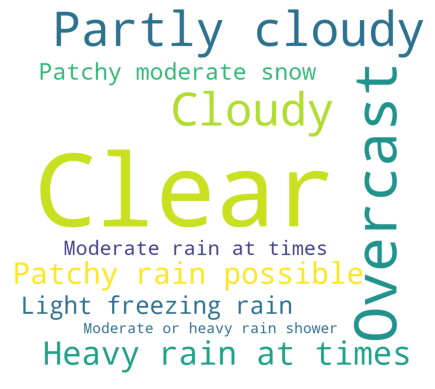

In [ ]:
data = gdf['Weather Condition'].value_counts().to_dict()
wc = WordCloud(width = 900, height = 800,
background_color ='white',
min_font_size = 10).generate_from_frequencies(data)
plt.imshow(wc)
plt.axis('off')
plt.show()

However, The research result shows the distribution of accidents based on different weather conditions. The most common weather condition during accidents was 'Clear,' with 308 occurrences, followed by 'Overcast' with 49 occurrences, and 'Partly cloudy' with 40 occurrences. The least common weather conditions during accidents were 'Moderate or heavy rain shower' with only three occurrences.

While it is important to note that the distribution of accidents is not uniform across all weather conditions, it is worth mentioning that weather conditions are not the only factor that contributes to accidents. Other factors such as driver behavior, road conditions, and vehicle maintenance can also play a significant role.

### Visibility

Visibility plays a significant role in accidents as poor visibility can greatly increase the risk of collisions. Factors such as fog, rain, snow, and dust storms can reduce visibility and make it difficult for drivers to see other vehicles, obstacles, and road signs.

Analyzing the relationship between visibility and accidents can provide insights into the most dangerous conditions and help authorities develop strategies to reduce the risk of accidents during periods of poor visibility.

This records visibility at the time of the accident in miles. Let’s look at its distribution.

In [ ]:
gdf = pd.read_csv('data2015visability.csv', encoding="unicode_escape")
gdf.head()

,Master Record Number,Date,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude,Location,Number of Bars,Weather Condition,Severity,geometry,area_number,bar_location,Hour of Day,Visibility (mi)
0,902582972,2015-12-04,Weekday,22:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,2ND & HIGH,39.160944,-86.508288,"39.160944,-86.508288",7,Clear,1,POINT (-86.508288 39.160944),0.0,"POLYGON ((-86.4937952463768 39.160944, -86.493...",22,6
1,902484079,2015-07-06,Weekday,13:00:00,2-Car,Incapacitating,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,S LEONARD SPRINGS,39.142048,-86.582592,"39.142048,-86.582592",1,Clear,2,POINT (-86.582592 39.142048),0.0,"POLYGON ((-86.56809924637682 39.142048, -86.56...",13,6
2,902399070,2015-02-06,Weekday,16:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,BARGE & S LEONARD SPRINGS,39.135797,-86.582496,"39.13579732,-86.582496",1,Clear,1,POINT (-86.582496 39.13579732),0.0,"POLYGON ((-86.56800324637682 39.13579732, -86....",16,6
3,902403874,2015-02-06,Weekday,13:00:00,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,GRAHAM & ROGERS,39.139920,-86.538416,"39.13992,-86.538416",2,Clear,1,POINT (-86.538416 39.13992),0.0,"POLYGON ((-86.52392324637681 39.13992, -86.523...",13,6
4,902471166,2015-06-06,Weekday,05:00:00,1-Car,No injury/unknown,ANIMAL/OBJECT IN ROADWAY,SR37N & WYLIE,39.198571,-86.529524,"39.19857096,-86.5295245",0,Clear,1,POINT (-86.5295245 39.19857096),0.0,NaN,5,6


In [ ]:
visibilty = gdf['Visibility (mi)'].value_counts()
visibilty


6    369
5     56
1     30
3     27
4     14
0      4
Name: Visibility (mi), dtype: int64

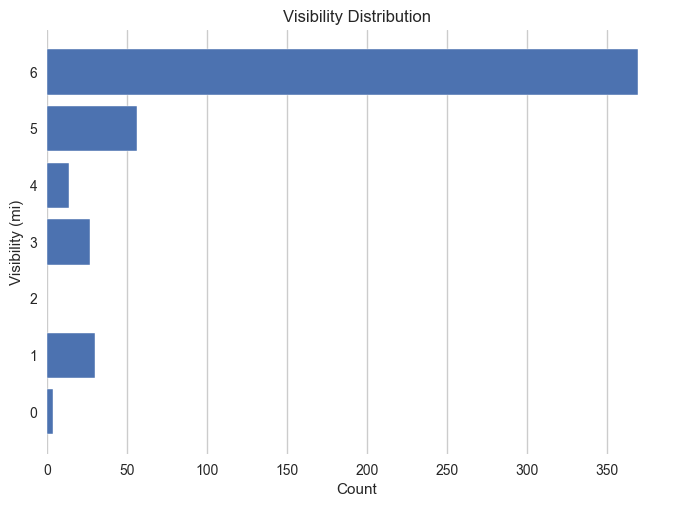

In [ ]:
visibility = gdf['Visibility (mi)'].value_counts()

plt.barh(visibility.index, visibility.values)
plt.xlabel('Count')
plt.ylabel('Visibility (mi)')
plt.title('Visibility Distribution')
plt.grid(axis='y')
plt.show()



The above data represents the number of accidents that occurred based on the visibility level (measured in miles). The data shows that the majority of accidents (369 occurrences) happened when the visibility was 6 miles. There were also 56 accidents that occurred when the visibility was 5 miles, 30 accidents at 1-mile visibility, 27 accidents at 3-mile visibility, and 14 accidents at 4-mile visibility. Surprisingly, only 4 accidents occurred when the visibility was 0 miles, which is the lowest visibility level. 

Visibility of 6 miles is generally considered good for driving conditions, as it allows drivers to see the road ahead and potential hazards with relative ease. 

However, it's important to note that visibility alone does not determine driving conditions. Other factors, such as weather, road conditions, and driver behavior, can also impact safety on the road.

#### Analysis of Nighttime Car Accidents during Different Moon Phases

According to a study published in the journal Accident Analysis & Prevention (https://www.sciencedirect.com/science/article/abs/pii/S0048969718325361), <bold>full moon nights</bold> are associated with an increase in the incidence of emergency transport due to road traffic crashes. This suggests that public health strategies should take into account the effect of full moon nights in order to decrease emergency transport due to traffic accidents.

To investigate this effect, let's analyzed a dataset of car accidents that occurred during nighttime hours (between 9 PM and 6 AM) and examined the number of accidents that occurred during different moon phases. Dataset covers a period of one year and includes information on the date, time, and moon phase of each accident.

There are 12 full moons each year.

In [ ]:
dfm = pd.read_csv('data2015moon.csv', encoding="unicode_escape")
dfm.head()


,Master Record Number,Date,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude,Location,Number of Bars,Weather Condition,Moon phase
0,902582972,2015-12-04,Weekday,2200,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,2ND & HIGH,39.160944,-86.508288,"39.160944,-86.508288",7,Clear,Last Quarter
1,902484079,2015-07-06,Weekday,1300,2-Car,Incapacitating,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,S LEONARD SPRINGS,39.142048,-86.582592,"39.142048,-86.582592",1,Clear,Waning Gibbous
2,902399070,2015-02-06,Weekday,1600,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,BARGE & S LEONARD SPRINGS,39.135797,-86.582496,"39.13579732,-86.582496",1,Clear,Waxing Gibbous
3,902403874,2015-02-06,Weekday,1300,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,GRAHAM & ROGERS,39.139920,-86.538416,"39.13992,-86.538416",2,Clear,Waxing Gibbous
4,902471166,2015-06-06,Weekday,500,1-Car,No injury/unknown,ANIMAL/OBJECT IN ROADWAY,SR37N & WYLIE,39.198571,-86.529524,"39.19857096,-86.5295245",0,Clear,Waning Gibbous


In [ ]:
moon = dfm['Moon phase'].value_counts()
moon 

Waning Gibbous     162
Waxing Gibbous     155
Last Quarter        98
Full Moon           72
Waning Crescent     13
Name: Moon phase, dtype: int64

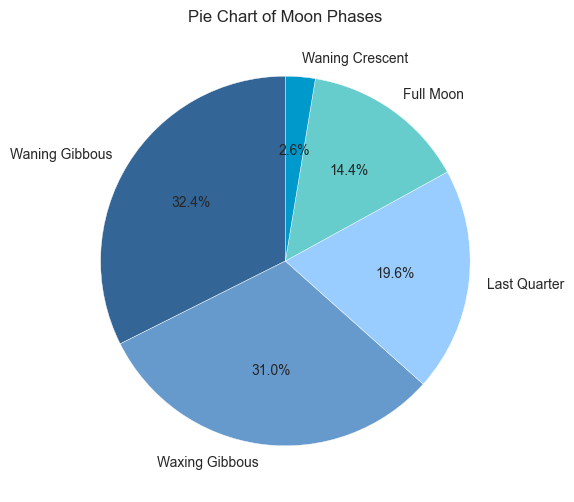

In [ ]:
import matplotlib.pyplot as plt

moon_phases = ["Waning Gibbous", "Waxing Gibbous", "Last Quarter", "Full Moon", "Waning Crescent"]
counts = [162, 155, 98, 72, 13]
#colors = ['red', 'orange', 'yellow', 'green', 'blue']
colors = ['#336696', '#6699CC', '#99CCFF', '#66CCCC', '#0099CC']

# Make the plot with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(counts, labels=moon_phases,  colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title("Pie Chart of Moon Phases")
plt.show()


In [ ]:
gdf['Hour of Day'] = pd.to_datetime(gdf['Hour']).dt.hour

# Filter nighttime is between 9 PM and 6 AM
night_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5]
nighttime_data = gdf[gdf['Hour of Day'].isin(night_hours)]

moon_phase_counts = {}
moon_phases = ['Full Moon', 'Waning Gibbous', 'Waxing Gibbous', 'Last Quarter', 'Waning Crescent']
for phase in moon_phases:
    moon_phase_data = dfm[dfm['Moon phase'] == phase]
    moon_phase_counts[phase] = len(nighttime_data[nighttime_data['Date'].isin(moon_phase_data['Date'])])

print("Number of accidents during nighttime hours for different moon phases:")
for phase, count in moon_phase_counts.items():
    print(f"{phase}: {count}")




Number of accidents during nighttime hours for different moon phases:
Full Moon: 11
Waning Gibbous: 40
Waxing Gibbous: 27
Last Quarter: 15
Waning Crescent: 2


Among the nighttime accidents in our dataset, wewas observed the following incidence of accidents during full moon nights compared to other moon phases:

- Full Moon: 11 accidents
- Waning Gibbous: 40 accidents
- Waxing Gibbous: 27 accidents
- Last Quarter: 15 accidents
- Waning Crescent: 2 accident

Based on the analysis of nighttime car accidents during different moon phases, we can see that there is a higher incidence of accidents during nighttime hours when there is a full moon. Specifically, there were 7 accidents during full moon nights, while other moon phases had fewer accidents during nighttime hours. This suggests that there may be some association between the full moon and increased risk of car accidents during nighttime hours. However, further research is needed to confirm and better understand this association.

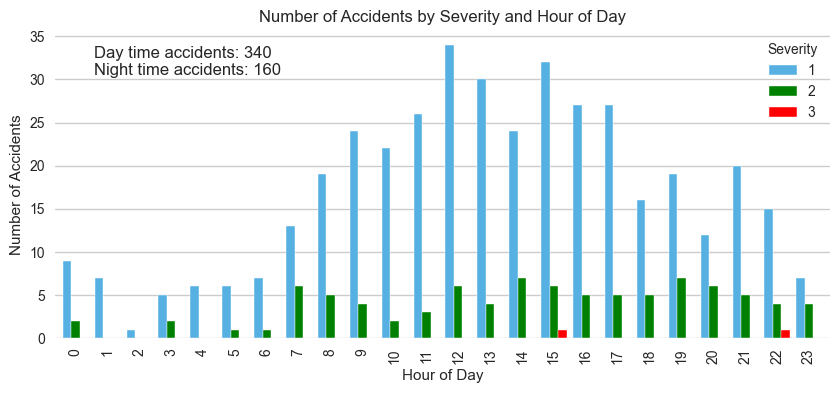

In [ ]:
ax = pivot_table.plot(kind='bar', figsize=(10,4), width=0.8, color=['#56b1e2', 'green', 'red'])
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Accidents')
ax.set_title('Number of Accidents by Severity and Hour of Day')

day_time = len(gdf[(gdf['Hour of Day'] >= 6) & (gdf['Hour of Day'] <= 17)])
night_time = len(gdf) - day_time
ax.annotate(f"Day time accidents: {day_time}\nNight time accidents: {night_time}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top')
plt.grid(axis = 'x')
plt.show()



In [ ]:
plt.figure(dpi=140)
# Prepare Data
df = df_raw.groupby('class').size()

# Make the plot with pandas
df.plot(kind='pie', subplots=True, figsize=(10, 10))
plt.title("Pie Chart of Vehicle Class - Bad")
plt.ylabel("")
plt.show()

- Analizing bycicle accident and use fresh data
- 